# GluonTS

Gluon Time Series (GluonTS) is an open source deep learning API developed by Amazon and Microsoft which allows devolopers to easily build deep-learning based machine learning models using Apache MXNet for probabilistic time series forecasting.

Gluonts provides functions for loading and preparing time series data with state of the art models readily availble that can be easily altered for the needs of the user. GluonTS offers various model architectures, such as sequence to sequence framework, autoregressive model networks and causal convolutions among various other methods.

For a more in depth discussion of the capabilitites of the GluonTS framework, follow the [link](https://github.com/awslabs/gluon-ts)

Load in the required libraries and python modules

In [1]:
evalpred:.p.import[`gluonts.evaluation.backtest]`:make_evaluation_predictions
trainer:.p.import[`gluonts.trainer]`:Trainer
deepar:.p.import[`gluonts.model.deepar]
sff:.p.import[`gluonts.model.simple_feedforward]
pd:.p.import[`pandas]
pylst:.p.import[`builtins][`:list]
plt:.p.import[`matplotlib.pyplot]

\l ml/ml.q
\l ml/init.q
\l ../utils.q

INFO:root:Using CPU
INFO:root:Using CPU


No shared object files for cutils.q, only q implementations available


## Daily Temp

### Data Preparation

Load in the required dataset.

The below dataset contains the mimimum daily temperatures reached in Melbourne during the period from January 1981 - Decemeber 1990.

Any null values are deleted from the dataset.

In [2]:
show mintemp:`date`temp xcol ("PF";enlist",")0:`:../data/dailytemp.csv

// Delete any null values
mintemp:delete from mintemp where temp =0N

date                          temp
----------------------------------
1981.01.01D00:00:00.000000000 20.7
1981.01.02D00:00:00.000000000 17.9
1981.01.03D00:00:00.000000000 18.8
1981.01.04D00:00:00.000000000 14.6
1981.01.05D00:00:00.000000000 15.8
1981.01.06D00:00:00.000000000 15.8
1981.01.07D00:00:00.000000000 15.8
1981.01.08D00:00:00.000000000 17.4
1981.01.09D00:00:00.000000000 21.8
1981.01.10D00:00:00.000000000 20  
1981.01.11D00:00:00.000000000 16.2
1981.01.12D00:00:00.000000000 13.3
1981.01.13D00:00:00.000000000 16.7
1981.01.14D00:00:00.000000000 21.5
1981.01.15D00:00:00.000000000 25  
1981.01.16D00:00:00.000000000 20.7
1981.01.17D00:00:00.000000000 20.6
1981.01.18D00:00:00.000000000 24.8
1981.01.19D00:00:00.000000000 17.7
1981.01.20D00:00:00.000000000 15.5
..


Any missing datetimes in the dataset are added for completeness.

Backfilling and forward fillign are then used to fill in these gaps

In [3]:
mintemp:datefill[`date;mintemp;1D]

// Back and forward fill the missing data
mintemp:.ml.filltab[mintemp;();`date;::]

The data is plotted below to portray the trends and cycles present in the dataset

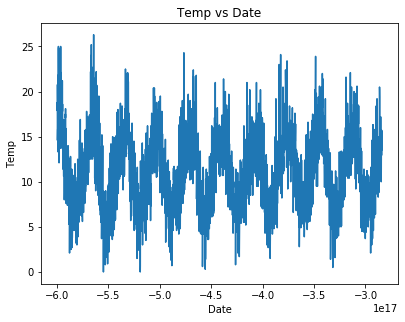

In [4]:
plttm[mintemp`date;mintemp`temp;"Temp"]

The dataset is then split into training and testing datasets (80/20). The dataset is split by date to ensure that no time leakage occurs

In [5]:
// Find the timestamp which splits the data 80/20
tts:ttstm[0.2;mintemp]

traintemp:tts`train
testtemp:tts`test

-1!"There is ",string[count traintemp]," datapoints in the training set"
-1!"There is ",string[count testtemp]," datapoints in the testing set"

"There is 2921 datapoints in the training set"


"There is 731 datapoints in the testing set"


In order for data to be passed through a GLuonTS model, the data must be in a specific format. This requires the data to have the following columns:

Column          | Explanation
----------------|-------------------------------
target          | a list of target values
start           | The start of the time series in a pandas timestamp format

### Preprocessing the Training data

In [6]:
// The initial date is transformed into a pandas timestamp
start:pd[`:Timestamp]["j"$("d"$first traintemp`date)-1970.01.01;`freq pykw "1H";`unit pykw "D"]`

// A table is made with the enlisted target values as the `target` column
show tab:([]target:enlist traintemp`temp;start:start)

target                                                                       ..
-----------------------------------------------------------------------------..
20.7 17.9 18.8 14.6 15.8 15.8 15.8 17.4 21.8 20 16.2 13.3 16.7 21.5 25 20.7 2..


This table must then be converted to a list of dictionaries in python. This then is transformed into a list of dictionaries using the `to_dict` attribute

In [7]:
// Convert to a pandas DF
gltab:.ml.tab2df tab

// Convert to a dictionary with orient set to `records` 
gltab:gltab[`:to_dict][`orient pykw `records]

GluonTS uses the model `ListDataset` to convert these dictionaries into a format that can be passed to the model.

The frequency of the timeseries can also be set, common frequencies include:

- `H` : Hourly
- `D` : Daily
- `M` : Monthly

In [8]:
// import the gluonts transformer
lstdata:.p.import[`gluonts.dataset.common]`:ListDataset

// Convert the data to a gluonts format, setting the frequency to daily
datalst:lstdata[gltab;`freq pykw "D"]

### Configuring an estimator

GlounTS comes with a number of prebuilt models with most models returning a probability distribution. These estimators include but are not limited to:

- Simple Feedforward 
- Deep Auto Regressors
- Reoccuccrent Neural Networks

An extensive list of the available models can be found on the link provided at the start of this tutorial

These models include required fields 

 `freq`: The  frequency of the timeseries in the dataset
 
 `prediction_length` : The amount of datapoints the model is to predict i.e the length of the test data
 
 An optioned field `trainer` is also available, which allows you to alter the parameters of the configured model, such as number of epochs, training rate etc

In the below model, a deep autoregrssive model is use, with the frequency set to 1 day, and prediction length set as the length of the testing data.

The trainer is also altered to run for 15 epochs

In [9]:
// Initiate the model
modeltemp:deepar[`:DeepAREstimator][`freq pykw "1D";`prediction_length pykw count testtemp;
    `trainer pykw trainer[`epochs pykw 5]]

INFO:root:Using CPU


### Training the model

After constructing an estimator with the appropriate hyperparameters, the estimator is then fitted on the training data, which creates the `Predictor` in GluonTS parlance.

In [10]:
// The model is trained passing the gluonts as input
\ts predicttemp:modeltemp[`:train][`training_data pykw datalst]

INFO:root:Start model training


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [04:54<00:00,  5.89s/it, avg_epoch_loss=2.88]
INFO:root:Epoch[0] Elapsed time 294.545 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=2.880472
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [03:04<00:00,  3.70s/it, avg_epoch_loss=2.49]
INFO:root:Epoch[1] Elapsed time 184.801 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=2.487518
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [02:16<00:00,  2.73s/it, avg_epoch_loss=2.43]
INFO:root:Epoch[2] Elapsed time 136.396 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=2.425168
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [02:31<00:00,  3.04s/it, avg_epoch_loss=2.36]
INFO:root:Epoch[3] Elapsed time 151.896 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=2.362303
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [02:31<00:00,  3.03s/it, avg_epoch_loss=2.32]
INFO:root:Epoch[4

921670 4196144


### Forecasting

The complete dataset (training and testing data inclusive) must also be preprocessed using the same steps outlined for the training data.

In [11]:
// The testing dataframe is transformed into a gluonts object, similar to above
// The training and testing values are now included 
show tst:([]target:enlist mintemp`temp;start: start)

tst:.ml.tab2df tst

tsttab:tst[`:to_dict][`orient pykw `records]

// Convert to gluonts format
datalsttst:lstdata[tsttab;`freq pykw "1D"]

target                                                                       ..
-----------------------------------------------------------------------------..
20.7 17.9 18.8 14.6 15.8 15.8 15.8 17.4 21.8 20 16.2 13.3 16.7 21.5 25 20.7 2..


This preprcoessed data can then be passed to the predictor, utilising the predict attribute of the model. When predicting forecasts, the model removes the final window from the dataset (equal to the length of the testing set, defined earlier in the notebook as `prediction_length`)

This must then be converted to a list. 

This returns a glounts object which contains attributes such as the frequency of the timeseries, along with the forecasted predictions

In [11]:
// The gluonts predicted object is converted to a list
predstemp:pylst[predicttemp[`:predict][datalsttst]]`

print predstemp

[gluonts.model.forecast.SampleForecast(freq="1D", info=None, item_id=None, samples=numpy.array([[10.777009963989258, 12.069600105285645, 9.160651206970215, 11.594003677368164, 12.796090126037598, 10.08347225189209, 12.096742630004883, 10.314088821411133, 13.075233459472656, 10.267194747924805, 12.298765182495117, 12.035836219787598, 12.713685989379883, 12.157108306884766, 10.459783554077148, 11.047041893005371, 16.731584548950195, 15.661805152893066, 11.302773475646973, 11.288722038269043, 11.789637565612793, 11.142791748046875, 9.406983375549316, 10.24920654296875, 14.13129711151123, 14.375818252563477, 12.117335319519043, 13.884057998657227, 15.963494300842285, 14.403539657592773, 14.868385314941406, 13.67007827758789, 16.493141174316406, 12.171453475952148, 10.900461196899414, 13.669121742248535, 14.804027557373047, 17.52820587158203, 8.861878395080566, 13.1763277053833, 13.991809844970703, 16.50680923461914, 19.040679931640625, 15.599541664123535, 20.205801010131836, 20.53715705871

[0;31mcall: bad argument type for built-in operation[0m: [0;31mcall: bad argument type for built-in operation[0m

In order to extract the predicted forecasts, the `samples` attribute of the list is extracted.

Multiple sample paths are created giving various "realisations" of the future predictions.

The average of all these paths are used as the forecasted predictions

In [12]:
// The samples from the list are extracted
forecast_pathstemp:(.p.wrap[predstemp[0]])[`:samples]`

-1!"There are ",string[count[forecast_pathstemp]]," sample paths"
-1!"Each path has ",string[count[forecast_pathstemp[0]]]," forecasted predictions"

// The average values of all these paths are taken as be the forecasted values
forecaststemp:avg forecast_pathstemp

"There are 100 sample paths"


"Each path has 731 forecasted predictions"


The error is calculated for the forecasted values compared to the true values

In [13]:
-1!"The Mean Squared Error is " ,string .ml.mse[testtemp`temp;forecaststemp]

"The Mean Squared Error is 7.405757"


The predicted and real values are also plotted to show how the models forecasted values varied from the true values

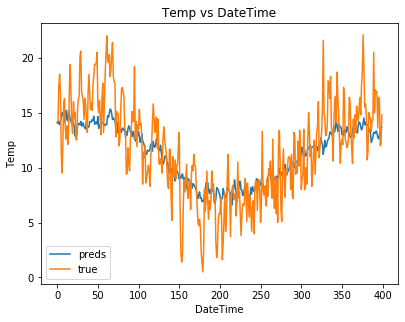

In [14]:
pltresult[400#forecaststemp;400#testtemp`temp;"Temp"]

The forecasted values follow the same overall increasing and decreasing trend of the dataset, however fail to capturn the correct values of the peaks and troughs at smaller intervals

## Bike Rental

**In this section a more complex model is used with exogenous variables included in the training of the models**

### Data Preparation

Load in the data

The dataset is a provided by TFL to predict future bike sales per hour. Additional data is also given in the form of seasonality and climate information such as season, indication of whether it is a holiday, temperature, wind_speed, current weather etc .

For the purpose of these notebook, when predictions are being made, it is assumed that these climate information will be available based off future weather predictions. 

In [15]:
show bikes:("PFFFFFFBFF";enlist ",")0:`:../data/london_merged.csv

timestamp                     cnt  t1  t2   hum  wind_speed weather_code is_h..
-----------------------------------------------------------------------------..
2015.01.04D00:00:00.000000000 182  3   2    93   6          3            0   ..
2015.01.04D01:00:00.000000000 138  3   2.5  93   5          1            0   ..
2015.01.04D02:00:00.000000000 134  2.5 2.5  96.5 0          1            0   ..
2015.01.04D03:00:00.000000000 72   2   2    100  0          1            0   ..
2015.01.04D04:00:00.000000000 47   2   0    93   6.5        1            0   ..
2015.01.04D05:00:00.000000000 46   2   2    93   4          1            0   ..
2015.01.04D06:00:00.000000000 51   1   -1   100  7          4            0   ..
2015.01.04D07:00:00.000000000 75   1   -1   100  7          4            0   ..
2015.01.04D08:00:00.000000000 131  1.5 -1   96.5 8          4            0   ..
2015.01.04D09:00:00.000000000 301  2   -0.5 100  9          3            0   ..
2015.01.04D10:00:00.000000000 528  3   -

The trends over time for the data is plotted below which shows that cyclical patterns are present in the dataset

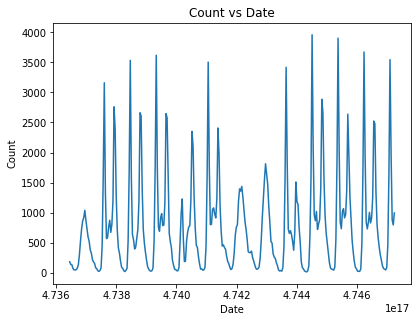

In [16]:
plttm[300#bikes`timestamp;300#bikes`cnt;"Count"]

The missing datetimes in the dataset are included, back and forward filling is used to fill these gaps.



In [17]:
// Include any missing datetimes
bikes:datefill[`timestamp;bikes;01:00:00.000]

// Back and forward fill the missing data
bikes:.ml.filltab[bikes;();`timestamp;::]

The data is then split into  a training and testing set (Making sure that no time leakage occurs). 

80% is chosen as train, 20% is testing data.

In [18]:
// Find the timestamp which splits the data 80/20
tts:ttstm[0.2;bikes]

trainbk:tts`train
testbk:tts`test

-1!"There is ",string[count trainbk]," datapoints in the training set"
-1!"There is ",string[count testbk]," datapoints in the testing set"

"There is 14035 datapoints in the training set"


"There is 3509 datapoints in the testing set"


The training data is converted to a gluonts appropriate format, similar to the steps taken above.

In this dataset, the frequency is set to be hourly

In [19]:
// The initial date is transformed into a pandas timestamp
start:pd[`:Timestamp]["j"$("d"$first bikes`timestamp)-1970.01.01;`freq pykw "1H";`unit pykw "D"]`

// A table is made with the enlisted target values as the `target` column and transformed to a pandas df
tab:.ml.tab2df([]target:enlist trainbk`cnt;start:enlist start)

// This is converted to a list of dictionaries
newt:tab[`:to_dict][`orient pykw `records]

// This is converted to a gluonts object
datalstbk:lstdata[newt;`freq pykw "1H"]

A Simple Feed Forward Estimator is initialised, defining the length and frequency of the training data. The parameters of the deep model are also altered, setting the epochs and learning rate to 20 and .001 respectively

In [20]:
modelbk:sff[`:SimpleFeedForwardEstimator][`freq pykw "1H";
    `prediction_length pykw count testbk;`trainer pykw trainer[`epochs pykw 8;`learning_rate pykw 0.001]]

INFO:root:Using CPU


The model is then trained using the gluonts formatted training data

In [21]:
\ts predictbk:modelbk[`:train][`training_data pykw datalstbk]

INFO:root:Start model training


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:12<00:00,  4.01it/s, avg_epoch_loss=8.16]
INFO:root:Epoch[0] Elapsed time 12.469 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.162293
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:11<00:00,  4.39it/s, avg_epoch_loss=7.77]
INFO:root:Epoch[1] Elapsed time 11.380 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.774086
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:11<00:00,  4.18it/s, avg_epoch_loss=7.67]
INFO:root:Epoch[2] Elapsed time 11.958 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.672238
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:18<00:00,  2.75it/s, avg_epoch_loss=7.65]
INFO:root:Epoch[3] Elapsed time 18.169 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.648185
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:18<00:00,  2.76it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[4] El

130119 4196144


The steps applied to the training data is applied to the testing data to transform it into the appropriate format

In [22]:
// The same methods as above are applied to the testing data
start:pd[`:Timestamp]["j"$("d"$first bikes`timestamp)-1970.01.01;`freq pykw "1H";`unit pykw "D"]`

tst:([]target:enlist bikes[`cnt];start: start)

tst:.ml.tab2df tst

tsttab:tst[`:to_dict][`orient pykw `records]

datalsttstbk:lstdata[tsttab;`freq pykw "1H"]

The future data is forecasted by extracting the final window from the complete dataset, defined as `prediction_length` when initialising the model

In [24]:
// Future values are forecasted using the model
predsbk:pylst[predictbk[`:predict][datalsttstbk]]`

// The samples from the list are extracted
forecast_pathsbk:(.p.wrap[predsbk[0]])[`:samples]`

-1!"There are ",string[count[forecast_pathsbk]]," sample paths"
-1!"Each path has ",string[count[forecast_pathsbk[0]]]," forecasted predictions"

// The average values of all these paths are taken as be the forecasted values
forecastsbk:avg forecast_pathsbk

"There are 100 sample paths"


"Each path has 3509 forecasted predictions"


The error is calculated for the prediction values compared to the true values

In [25]:
-1!"The root mean squared log error is " ,string .ml.rmsle[testbk`cnt;forecastsbk]

"The root mean squared log error is 1.777457"


The predicted and true values are plotted to compare

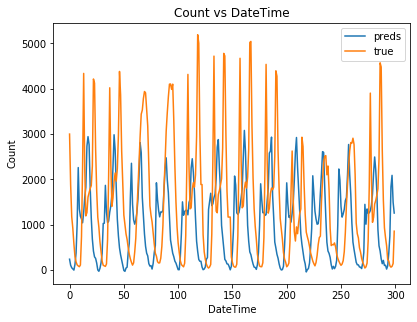

'2020.03.31T18:59:44.003 timeout reporting -- exiting

In [26]:
pltresult[300#forecastsbk;300#testbk`cnt;"Count"]

Similar to above, the forecasted values seem to capture the overall trends present in the dataset but fail to predict the correct values of the peaks. The trough forecasts present sre relatively similar to that of the actual values.